In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import tqdm
import time

df = pd.read_csv('data/train.csv')
print('Shape:', df.shape)
print(df.head())

Shape: (42000, 785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         

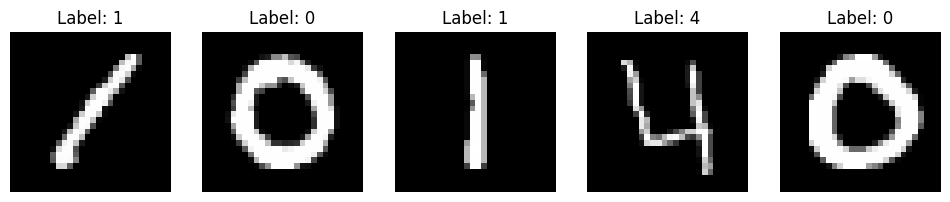

In [2]:

samples_count = 5
fig, axes = plt.subplots(1, samples_count, figsize=(12, 3))
for i in range(samples_count):
    label = df.iloc[i, 0]
    pixels = df.iloc[i, 1:].values.reshape(28, 28)
    axes[i].imshow(pixels, cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')
plt.show()

In [3]:

class MNISTDataset(Dataset):
    def __init__(self, dataframe):
        self.labels = dataframe.iloc[:, 0].values.astype(np.int64)
        self.images = dataframe.iloc[:, 1:].values.astype(np.float32) / 255.0
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        x = torch.tensor(self.images[idx])
        y = torch.tensor(self.labels[idx])
        return x, y

dataset = MNISTDataset(df)
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [4]:

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'])

train_loader = DataLoader(MNISTDataset(train_df), batch_size=512, shuffle=True)
test_loader = DataLoader(MNISTDataset(test_df), batch_size=512, shuffle=False)

print(f'Train size: {len(train_df)}, Test size: {len(test_df)}')

Train size: 33600, Test size: 8400


In [5]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.1)
        self.skip = nn.Linear(512, 128)
        self.act = nn.ReLU()
    def forward(self, x):
        x1 = self.act(self.fc1(x))
        x1 = self.dropout1(x1)
        x2 = self.act(self.fc2(x1))
        x2 = self.dropout2(x2)
        x3 = self.act(self.fc3(x2))
        x3 = self.dropout3(x3)
        x3 = x3 + self.skip(x1)
        out = self.fc4(x3)
        return out

model = MLP()
print(model)

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (dropout3): Dropout(p=0.1, inplace=False)
  (skip): Linear(in_features=512, out_features=128, bias=True)
  (act): ReLU()
)


In [6]:

training_started = time.time()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
epochs = 10
best_acc = 0
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm.tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f}')
    
training_time = time.time() - training_started
torch.save(model.state_dict(), 'models/neural_network_model.pth')

Epoch 1/10: 100%|██████████| 66/66 [00:02<00:00, 24.98it/s]


Epoch 1/10 - Loss: 0.8266 - Acc: 0.7942


Epoch 2/10: 100%|██████████| 66/66 [00:02<00:00, 24.71it/s]


Epoch 2/10 - Loss: 0.2913 - Acc: 0.9145


Epoch 3/10: 100%|██████████| 66/66 [00:02<00:00, 24.75it/s]


Epoch 3/10 - Loss: 0.2174 - Acc: 0.9364


Epoch 4/10: 100%|██████████| 66/66 [00:02<00:00, 25.96it/s]


Epoch 4/10 - Loss: 0.1706 - Acc: 0.9498


Epoch 5/10: 100%|██████████| 66/66 [00:02<00:00, 24.68it/s]


Epoch 5/10 - Loss: 0.1385 - Acc: 0.9582


Epoch 6/10: 100%|██████████| 66/66 [00:02<00:00, 23.20it/s]


Epoch 6/10 - Loss: 0.1153 - Acc: 0.9660


Epoch 7/10: 100%|██████████| 66/66 [00:02<00:00, 24.56it/s]


Epoch 7/10 - Loss: 0.0957 - Acc: 0.9710


Epoch 8/10: 100%|██████████| 66/66 [00:02<00:00, 24.40it/s]


Epoch 8/10 - Loss: 0.0805 - Acc: 0.9753


Epoch 9/10: 100%|██████████| 66/66 [00:02<00:00, 24.07it/s]


Epoch 9/10 - Loss: 0.0692 - Acc: 0.9792


Epoch 10/10: 100%|██████████| 66/66 [00:03<00:00, 18.15it/s]


Epoch 10/10 - Loss: 0.0601 - Acc: 0.9816


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
def evaluate(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)
    return acc, prec, rec, f1, cm

testing_started = time.time()
acc, prec, rec, f1, cm = evaluate(model, test_loader)
testing_time = time.time() - testing_started

In [8]:

from pathlib import Path
model_params = sum(p.numel() for p in model.parameters())
model_path = Path('models/neural_network_model.pth')
if model_path.exists():
    size_mb = model_path.stat().st_size / (1024 * 1024)
else:
    size_mb = 0

# Summarize prediction time
print('--- Summary ---')
print(f'Kích thước Train dataset: {len(train_df)}')
print(f'Kích thước Test dataset: {len(test_df)}')
print("----------------------------")
print(f"Thời gian huấn luyện: {training_time:.4f}")
print(f"Thời gian dự đoán trên Test dataset: {testing_time:.5f}")
print(f'Thời gian dự đoán trung bình mỗi mẫu: {(testing_time / len(test_df)):.10f}')
print("----------------------------")
print(f'Accuracy: {acc:.4f}')
print(f'Precision: {prec:.4f}')
print(f'Recall: {rec:.4f}')
print(f'F1 Score: {f1:.4f}')
print("----------------------------")
print('Confusion Matrix:')
print(cm)
print("----------------------------")
print(f'Số tham số của mô hình: {model_params}')
print(f'Kích thước mô hình: {size_mb:.4f} MB')
print("----------------------------")

--- Summary ---
Kích thước Train dataset: 33600
Kích thước Test dataset: 8400
----------------------------
Thời gian huấn luyện: 30.2928
Thời gian dự đoán trên Test dataset: 0.33194
Thời gian dự đoán trung bình mỗi mẫu: 0.0000395168
----------------------------
Accuracy: 0.9755
Precision: 0.9753
Recall: 0.9754
F1 Score: 0.9753
----------------------------
Confusion Matrix:
[[809   0   0   0   1   1   9   1   5   1]
 [  0 924   4   3   1   0   0   0   3   2]
 [  1   2 808   3   2   1   0  11   7   0]
 [  1   2   3 834   0  13   0   4  10   3]
 [  1   3   1   0 791   0   4   1   1  12]
 [  3   0   0   6   0 743   3   0   1   3]
 [  3   2   0   0   1   1 816   0   4   0]
 [  0   0   3   0   4   2   0 864   1   6]
 [  2   5   3   0   3   6   2   0 786   6]
 [  1   0   0   0   8   1   0   8   1 819]]
----------------------------
Số tham số của mô hình: 633098
Kích thước mô hình: 2.4192 MB
----------------------------
